In [ ]:
import sys

from SVERL_icml_2023.portfolio_DRL.data_function import *
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import math
from torch.utils.data import Dataset, DataLoader
from SVERL_icml_2023.portfolio_DRL.create_model import *
from sklearn.model_selection import TimeSeriesSplit
from SVERL_icml_2023.shapley import Shapley
import shap
sys.path.append("E:/XAI/RL_with_SHAP/pythonProject1/SVERL_icml_2023")
# from portfolio_DRL.create_model import StockPredictWrapper
import pandas as pd
import numpy as np
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.callbacks import EvalCallback
import pandas as pd
import numpy as np
import gymnasium as gym
from gym import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
import os

Total SHAP records (Test Phase): 12964


C:\Users\Jiayang\AppData\Local\Temp\ipykernel_23568\1030685635.py:51: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  flat_regimes = pivot_daily_regimes.stack(level=1)


start find clusters ......
find the labels
get the inertia, silhouette_avg and calinski_harabasz
Clusters: 2, Inertia: 2211983.58, Silhouette: 0.8054, Calinski-Harabasz: 39172.67
start find clusters ......
find the labels
get the inertia, silhouette_avg and calinski_harabasz
Clusters: 3, Inertia: 1981707.57, Silhouette: 0.7540, Calinski-Harabasz: 32436.26
start find clusters ......
find the labels
get the inertia, silhouette_avg and calinski_harabasz
Clusters: 4, Inertia: 1800233.70, Silhouette: 0.2491, Calinski-Harabasz: 29919.77
start find clusters ......
find the labels
get the inertia, silhouette_avg and calinski_harabasz
Clusters: 5, Inertia: 1686148.84, Silhouette: 0.1134, Calinski-Harabasz: 27036.06
start find clusters ......
find the labels
get the inertia, silhouette_avg and calinski_harabasz
Clusters: 6, Inertia: 1598954.39, Silhouette: 0.1127, Calinski-Harabasz: 24793.18
start find clusters ......
find the labels
get the inertia, silhouette_avg and calinski_harabasz
Clusters

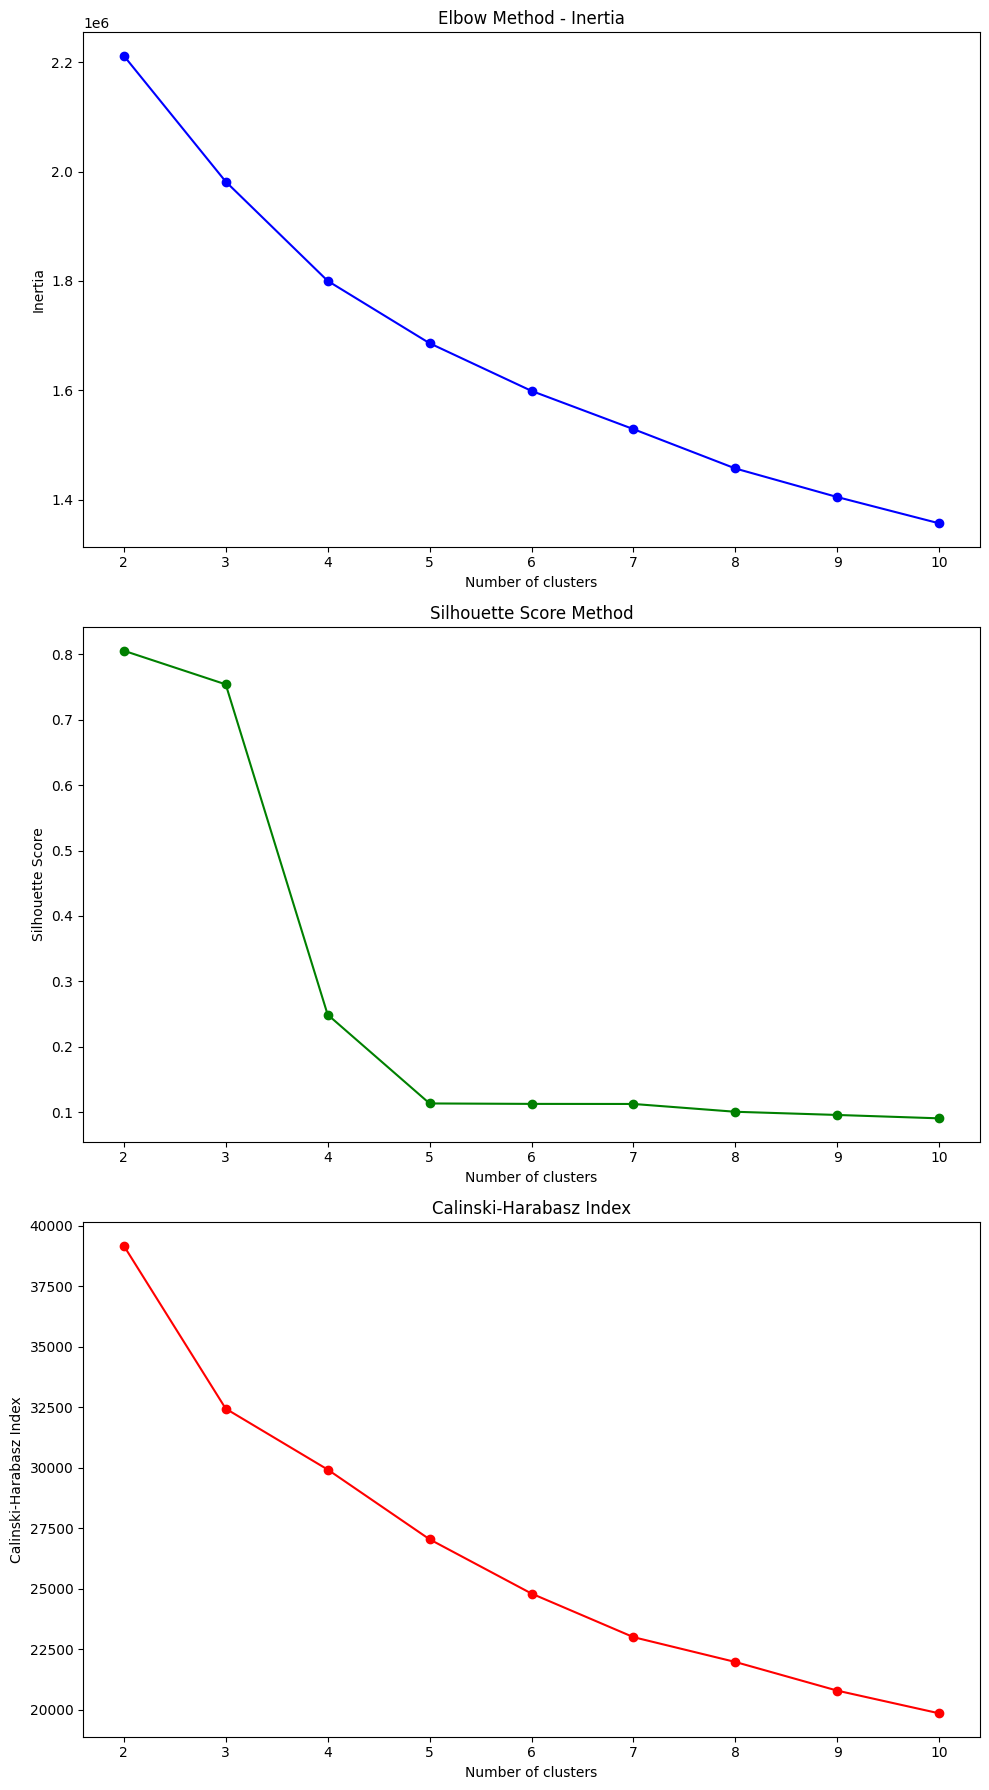

In [24]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Load data explicitly
shap_metrics = pd.read_csv('shap_value_metrics_export.csv', parse_dates=['Start_Date', 'End_Date'])
factor_returns = pd.read_csv('aligned_factors.csv', parse_dates=['Date'], index_col='Date')
stock_returns = pd.read_csv('daily_returns.csv', parse_dates=['Date'], index_col='Date')

# Explicitly filter only 'Test' phase SHAP metrics
shap_metrics_test = shap_metrics[shap_metrics['Phase'] == 'Test'].copy()

print(f"Total SHAP records (Test Phase): {len(shap_metrics_test)}")

# Select SHAP metrics explicitly
selected_columns = [
    'mean_abs_shap_Mkt-RF', 'mean_abs_shap_SMB', 'mean_abs_shap_HML',
    'mean_abs_shap_RMW', 'mean_abs_shap_CMA',
    'shap_std_Mkt-RF', 'shap_std_SMB', 'shap_std_HML',
    'shap_std_RMW', 'shap_std_CMA',
    'mean_abs_over_std_Mkt-RF', 'mean_abs_over_std_SMB', 'mean_abs_over_std_HML',
    'mean_abs_over_std_RMW', 'mean_abs_over_std_CMA'
]

# Explicitly scale SHAP metrics per stock without aggregation
scaler_shap = StandardScaler()
shap_metrics_test[selected_columns] = scaler_shap.fit_transform(shap_metrics_test[selected_columns])

# Map SHAP intervals explicitly to daily returns by stock
expanded_daily_regimes = []
for _, row in shap_metrics_test.iterrows():
    date_range = pd.date_range(row['Start_Date'], row['End_Date'])
    temp_df = pd.DataFrame({
        'Date': date_range,
        'Ticker': row['Stock'],
        **{col: row[col] for col in selected_columns}
    })
    expanded_daily_regimes.append(temp_df)

expanded_daily_regimes_df = pd.concat(expanded_daily_regimes)

# Pivot explicitly to have tickers and dates
pivot_daily_regimes = expanded_daily_regimes_df.pivot_table(
    index='Date', columns='Ticker', values=selected_columns
)
pivot_daily_regimes.ffill(inplace=True)
pivot_daily_regimes.dropna(inplace=True)

# Perform KMeans clustering explicitly on reshaped data
flat_regimes = pivot_daily_regimes.stack(level=1)
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score
import matplotlib.pyplot as plt

# Prepare data explicitly
X = flat_regimes[selected_columns].values

# Define range for number of clusters
cluster_range = range(2, 11)

# Initialize lists to store metrics
inertia_list = []
silhouette_list = []
calinski_harabasz_list = []

# Compute metrics for each number of clusters
for n_clusters in cluster_range:
    print(f'start find clusters ......')
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X)
    print(f'find the labels')
    
    inertia = kmeans.inertia_
    silhouette_avg = silhouette_score(X, labels, sample_size=10000, random_state=42)
    calinski_harabasz = calinski_harabasz_score(X, labels)
    print(f'get the inertia, silhouette_avg and calinski_harabasz')
    inertia_list.append(inertia)
    silhouette_list.append(silhouette_avg)
    calinski_harabasz_list.append(calinski_harabasz)
    print(f"Clusters: {n_clusters}, Inertia: {inertia:.2f}, "
          f"Silhouette: {silhouette_avg:.4f}, Calinski-Harabasz: {calinski_harabasz:.2f}")

# Plotting metrics explicitly
fig, axs = plt.subplots(3, 1, figsize=(10, 18))

# Elbow method (Inertia)
axs[0].plot(cluster_range, inertia_list, 'o-', color='blue')
axs[0].set_xlabel('Number of clusters')
axs[0].set_ylabel('Inertia')
axs[0].set_title('Elbow Method - Inertia')

# Silhouette Score
axs[1].plot(cluster_range, silhouette_list, 'o-', color='green')
axs[1].set_xlabel('Number of clusters')
axs[1].set_ylabel('Silhouette Score')
axs[1].set_title('Silhouette Score Method')

# Calinski-Harabasz Index
axs[2].plot(cluster_range, calinski_harabasz_list, 'o-', color='red')
axs[2].set_xlabel('Number of clusters')
axs[2].set_ylabel('Calinski-Harabasz Index')
axs[2].set_title('Calinski-Harabasz Index')

plt.tight_layout()
plt.show()


# kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
# flat_regimes['Cluster'] = kmeans.fit_predict(flat_regimes[selected_columns])
# 
# # Normalize explicitly factor returns
# factor_scaler = StandardScaler()
# factor_returns_norm = pd.DataFrame(
#     factor_scaler.fit_transform(factor_returns),
#     index=factor_returns.index,
#     columns=factor_returns.columns
# )
# 
# # Normalize explicitly stock returns
# stock_scaler = StandardScaler()
# stock_returns_norm = pd.DataFrame(
#     stock_scaler.fit_transform(stock_returns),
#     index=stock_returns.index,
#     columns=stock_returns.columns
# )
# 
# # Merge explicitly into final dataset (flattened multi-index)
# merged_data = stock_returns_norm.stack().rename('Return').to_frame()
# merged_data.index.names = ['Date', 'Ticker']
# merged_data = merged_data.join(flat_regimes[['Cluster'] + selected_columns]).dropna()
# merged_data = merged_data.reset_index().pivot(index='Date', columns='Ticker')
# merged_data.columns = ['_'.join(col).strip() for col in merged_data.columns.values]
# 
# # Join explicitly factor returns
# merged_data = merged_data.join(factor_returns_norm, how='inner').dropna()
# 
# # Save explicitly final aligned dataset
# merged_data.to_csv("final_merged_data.csv")
# 
# # Explicitly filter raw stock returns to match the merged_data dates
# start_date, end_date = merged_data.index.min(), merged_data.index.max()
# raw_stock_returns = stock_returns.loc[start_date:end_date].copy()
# 
# # Unstack clusters explicitly and rename columns to avoid overlap
# clusters_unstacked = flat_regimes['Cluster'].unstack().rename(columns=lambda x: f"{x}_cluster")
# 
# # Explicitly join raw returns and clusters without column overlap
# aligned_returns_clusters = raw_stock_returns.join(clusters_unstacked, how='inner')
# 
# # Compute explicit cluster average returns
# cluster_avg_returns = {}
# for cluster_label in np.unique(flat_regimes['Cluster']):
#     # Identify stocks belonging to this cluster
#     cluster_stocks = clusters_unstacked.columns[clusters_unstacked.iloc[0] == cluster_label]
#     cluster_stocks = [col.replace('_cluster', '') for col in cluster_stocks]
#     
#     # Compute mean return across stocks for each cluster
#     cluster_avg_returns[cluster_label] = aligned_returns_clusters[cluster_stocks].mean(axis=1).mean()
# 
# print("Explicit Cluster Mean Returns Check:\n", cluster_avg_returns)



In [28]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Load data explicitly
shap_metrics = pd.read_csv('shap_value_metrics_export.csv', parse_dates=['Start_Date', 'End_Date'])
factor_returns = pd.read_csv('aligned_factors.csv', parse_dates=['Date'], index_col='Date')
stock_returns = pd.read_csv('daily_returns.csv', parse_dates=['Date'], index_col='Date')

# Explicitly filter only 'Test' phase SHAP metrics
shap_metrics_test = shap_metrics[shap_metrics['Phase'] == 'Test'].copy()

print(f"Total SHAP records (Test Phase): {len(shap_metrics_test)}")

# Select SHAP metrics explicitly
selected_columns = [
    'mean_abs_shap_Mkt-RF', 'mean_abs_shap_SMB', 'mean_abs_shap_HML',
    'mean_abs_shap_RMW', 'mean_abs_shap_CMA',
    'shap_std_Mkt-RF', 'shap_std_SMB', 'shap_std_HML',
    'shap_std_RMW', 'shap_std_CMA',
    'mean_abs_over_std_Mkt-RF', 'mean_abs_over_std_SMB', 'mean_abs_over_std_HML',
    'mean_abs_over_std_RMW', 'mean_abs_over_std_CMA'
]

# Explicitly scale SHAP metrics per stock without aggregation
scaler_shap = StandardScaler()
shap_metrics_test[selected_columns] = scaler_shap.fit_transform(shap_metrics_test[selected_columns])

# Map SHAP intervals explicitly to daily returns by stock
expanded_daily_regimes = []
for _, row in shap_metrics_test.iterrows():
    date_range = pd.date_range(row['Start_Date'], row['End_Date'])
    temp_df = pd.DataFrame({
        'Date': date_range,
        'Ticker': row['Stock'],
        **{col: row[col] for col in selected_columns}
    })
    expanded_daily_regimes.append(temp_df)

expanded_daily_regimes_df = pd.concat(expanded_daily_regimes)

# Pivot explicitly to have tickers and dates
pivot_daily_regimes = expanded_daily_regimes_df.pivot_table(
    index='Date', columns='Ticker', values=selected_columns
)
pivot_daily_regimes.ffill(inplace=True)
pivot_daily_regimes.dropna(inplace=True)

# Perform KMeans clustering explicitly on reshaped data
flat_regimes = pivot_daily_regimes.stack(level=1)
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
flat_regimes['Cluster'] = kmeans.fit_predict(flat_regimes[selected_columns])

# Normalize explicitly factor returns
factor_scaler = StandardScaler()
factor_returns_norm = pd.DataFrame(
    factor_scaler.fit_transform(factor_returns),
    index=factor_returns.index,
    columns=factor_returns.columns
)

# Normalize explicitly stock returns
stock_scaler = StandardScaler()
stock_returns_norm = pd.DataFrame(
    stock_scaler.fit_transform(stock_returns),
    index=stock_returns.index,
    columns=stock_returns.columns
)

# Merge explicitly into final dataset (flattened multi-index)
merged_data = stock_returns_norm.stack().rename('Return').to_frame()
merged_data.index.names = ['Date', 'Ticker']
merged_data = merged_data.join(flat_regimes[['Cluster'] + selected_columns]).dropna()
merged_data = merged_data.reset_index().pivot(index='Date', columns='Ticker')
merged_data.columns = ['_'.join(col).strip() for col in merged_data.columns.values]

# Join explicitly factor returns
merged_data = merged_data.join(factor_returns_norm, how='inner').dropna()

# Save explicitly final aligned dataset
merged_data.to_csv("final_merged_data.csv")

# Explicitly filter raw stock returns to match the merged_data dates
start_date, end_date = merged_data.index.min(), merged_data.index.max()
raw_stock_returns = stock_returns.loc[start_date:end_date].copy()

# Unstack clusters explicitly and rename columns to avoid overlap
clusters_unstacked = flat_regimes['Cluster'].unstack().rename(columns=lambda x: f"{x}_cluster")

# Explicitly join raw returns and clusters without column overlap
aligned_returns_clusters = raw_stock_returns.join(clusters_unstacked, how='inner')

cluster_avg_returns = {}

# Iterate through each unique cluster
for cluster_label in np.unique(flat_regimes['Cluster']):
    # Select dates and tickers belonging to the current cluster
    cluster_data = flat_regimes[flat_regimes['Cluster'] == cluster_label]

    # Pivot the data to have dates as index and tickers as columns
    cluster_pivot = cluster_data.reset_index().pivot(index='Date', columns='Ticker', values='Cluster')

    # Identify common dates between returns and cluster data
    common_dates = raw_stock_returns.index.intersection(cluster_pivot.index)

    # Identify common tickers between returns and cluster data
    common_tickers = raw_stock_returns.columns.intersection(cluster_pivot.columns)

    # Extract the aligned returns
    aligned_returns = raw_stock_returns.loc[common_dates, common_tickers]

    # Calculate the mean returns (across tickers, then across dates)
    avg_return = aligned_returns.mean(axis=1).mean()

    # Store the result
    cluster_avg_returns[cluster_label] = avg_return

print("Explicit Cluster Mean Returns Check:\n", cluster_avg_returns)



Total SHAP records (Test Phase): 12964


C:\Users\Jiayang\AppData\Local\Temp\ipykernel_23568\746946117.py:51: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  flat_regimes = pivot_daily_regimes.stack(level=1)


Explicit Cluster Mean Returns Check:
 {np.int32(0): np.float64(0.0006691158359693879), np.int32(1): np.float64(-0.0013690204382653067)}


In [29]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Load data explicitly
shap_metrics = pd.read_csv('shap_value_metrics_export.csv', parse_dates=['Start_Date', 'End_Date'])
factor_returns = pd.read_csv('aligned_factors.csv', parse_dates=['Date'], index_col='Date')
stock_returns = pd.read_csv('daily_returns.csv', parse_dates=['Date'], index_col='Date')

# Explicitly filter only 'Test' phase SHAP metrics
shap_metrics_test = shap_metrics[shap_metrics['Phase'] == 'Test'].copy()

print(f"Total SHAP records (Test Phase): {len(shap_metrics_test)}")

# Select SHAP metrics explicitly
selected_columns = [
    'mean_abs_shap_Mkt-RF', 'mean_abs_shap_SMB', 'mean_abs_shap_HML',
    'mean_abs_shap_RMW', 'mean_abs_shap_CMA',
    'shap_std_Mkt-RF', 'shap_std_SMB', 'shap_std_HML',
    'shap_std_RMW', 'shap_std_CMA',
    'mean_abs_over_std_Mkt-RF', 'mean_abs_over_std_SMB', 'mean_abs_over_std_HML',
    'mean_abs_over_std_RMW', 'mean_abs_over_std_CMA'
]

# Explicitly scale SHAP metrics per stock without aggregation
scaler_shap = StandardScaler()
shap_metrics_test[selected_columns] = scaler_shap.fit_transform(shap_metrics_test[selected_columns])

# Map SHAP intervals explicitly to daily returns by stock
expanded_daily_regimes = []
for _, row in shap_metrics_test.iterrows():
    date_range = pd.date_range(row['Start_Date'], row['End_Date'])
    temp_df = pd.DataFrame({
        'Date': date_range,
        'Ticker': row['Stock'],
        **{col: row[col] for col in selected_columns}
    })
    expanded_daily_regimes.append(temp_df)

expanded_daily_regimes_df = pd.concat(expanded_daily_regimes)

# Pivot explicitly to have tickers and dates
pivot_daily_regimes = expanded_daily_regimes_df.pivot_table(
    index='Date', columns='Ticker', values=selected_columns
)
pivot_daily_regimes.ffill(inplace=True)
pivot_daily_regimes.dropna(inplace=True)

# Perform KMeans clustering explicitly on reshaped data
flat_regimes = pivot_daily_regimes.stack(level=1)
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
flat_regimes['Cluster'] = kmeans.fit_predict(flat_regimes[selected_columns])
flat_regimes['Cluster']

Total SHAP records (Test Phase): 12964


C:\Users\Jiayang\AppData\Local\Temp\ipykernel_23568\2049681494.py:51: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  flat_regimes = pivot_daily_regimes.stack(level=1)


Date        Ticker
2006-06-09  AAPL      0
            AMGN      0
            AMZN      0
            AXP       0
            BA        0
                     ..
2024-10-30  PG        0
            TRV       0
            UNH       0
            VZ        0
            WMT       0
Name: Cluster, Length: 182000, dtype: int32

In [ ]:
import gym
import numpy as np
from gym import spaces

class RegimeSelectorEnv(gym.Env):
    def __init__(self, shap_features_df, future_market_returns_series, regime_labels_series):
        super().__init__()
        
        # Stock-level SHAP metrics (for all stocks) as regime features
        self.shap_features = shap_features_df.values
        self.future_market_returns = future_market_returns_series.values
        self.regime_labels = regime_labels_series.values  # True historical regime labels
        
        self.current_step = 0
        self.n_regimes = len(np.unique(self.regime_labels))

        self.action_space = spaces.Discrete(self.n_regimes)
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf,
            shape=(self.shap_features.shape[1],),
            dtype=np.float32
        )

        # Regime average returns to calibrate reward magnitude
        self.historical_regime_returns = {
            regime: np.mean(self.future_market_returns[self.regime_labels == regime])
            for regime in range(self.n_regimes)
        }

    def reset(self):
        self.current_step = 0
        return self.shap_features[self.current_step]

    def step(self, action):
        actual_regime = self.regime_labels[self.current_step]

        # The actual market future return over the prediction horizon (e.g., next 21 days)
        realized_future_return = self.future_market_returns[self.current_step]

        # Reward explicitly encourages correctly identifying the regime,
        # scaled by absolute magnitude of market future return.
        if action == actual_regime:
            reward = 1 + abs(realized_future_return)  # Positive scaling with realized return magnitude
        else:
            reward = - 0.5 * (1 + abs(realized_future_return))  # Penalize strongly when wrong
        
        self.current_step += 1
        done = self.current_step >= len(self.shap_features) - 1

        obs = (
            self.shap_features[self.current_step]
            if not done else np.zeros(self.observation_space.shape)
        )

        return obs, reward, done, {}

import gym
import numpy as np
from gym import spaces

class RegimeConditionedPortfolioEnv(gym.Env):
    def __init__(self, stock_returns_df, stock_shap_features_df, chosen_regime_vector, raw_stock_returns_df, factor_returns_df=None):
        super().__init__()
        
        self.stock_returns = stock_returns_df.values
        self.shap_features = stock_shap_features_df.values
        self.chosen_regime_vector = chosen_regime_vector
        self.raw_stock_returns = raw_stock_returns_df.values
        self.factor_returns = factor_returns_df.values if factor_returns_df is not None else None
        
        self.current_step = 0
        self.n_assets = self.stock_returns.shape[1]

        self.action_space = spaces.Box(low=0, high=1, shape=(self.n_assets,), dtype=np.float32)

        obs_dim = self.n_assets + 1 + self.shap_features.shape[1]
        if self.factor_returns is not None:
            obs_dim += self.factor_returns.shape[1]

        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(obs_dim,), dtype=np.float32
        )

        self.rolling_window = 21  # rolling window for stable volatility calculation

    def reset(self):
        self.current_step = 0
        return self._get_obs()

    def _get_obs(self):
        returns = self.stock_returns[self.current_step]
        shap_metrics = self.shap_features[self.current_step]
        regime = np.array([self.chosen_regime_vector[self.current_step]])

        obs = np.concatenate([returns, regime, shap_metrics])

        if self.factor_returns is not None:
            factor_obs = self.factor_returns[self.current_step]
            obs = np.concatenate([obs, factor_obs])

        return np.nan_to_num(obs)

    def step(self, action):
        action_sum = action.sum()
        if action_sum == 0:
            action = np.ones_like(action) / len(action)
        else:
            action = action / action_sum

        realized_return = np.dot(action, self.raw_stock_returns[self.current_step + 1])

        # Rolling portfolio volatility
        start_idx = max(0, self.current_step - self.rolling_window + 1)
        recent_returns = self.raw_stock_returns[start_idx:self.current_step + 1]
        portfolio_returns = recent_returns @ action
        volatility = np.std(portfolio_returns) if len(portfolio_returns) > 1 else 0.01  # ensure numerical stability

        # Robust Reward: Sharpe ratio adjusted by SHAP-derived signals
        # SHAP stability metric (mean of absolute SHAP) as confidence indicator
        shap_confidence = np.mean(self.shap_features[self.current_step])
        sharpe_ratio = realized_return / (volatility + 1e-6)

        # Incorporating SHAP confidence explicitly into reward (high SHAP confidence amplifies the reward)
        reward = sharpe_ratio * (1 + shap_confidence)

        self.current_step += 1
        done = self.current_step >= len(self.stock_returns) - 1

        obs = self._get_obs() if not done else np.zeros(self.observation_space.shape)

        reward = 0.0 if np.isnan(reward) else reward

        return obs, reward, done, {}


In [ ]:
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
import os
import pandas as pd
import numpy as np

model_save_dir = 'E:/XAI/RL_with_SHAP/pythonProject1/SVERL_icml_2023/portfolio_DRL/trained_hierarchical_model/'

train_window, test_window = 252, 63
rebalance_freq = 21
use_factor_returns = False  # Set this flag as needed
tickers = stock_returns_norm.columns.tolist()
regime_columns = daily_regimes.columns.tolist()
factor_columns = factor_returns_norm.columns.tolist() if use_factor_returns else []
records = []
raw_stock_returns = stock_returns_norm_filter
load_existing_model = False
total_windows = len(range(0, len(merged_data) - train_window - test_window, test_window))

for i, start in enumerate(range(0, len(merged_data) - train_window - test_window, test_window)):
    print(f"\n{'='*30}\nStarting Hierarchical Training Window {i+1}/{total_windows}")
    high_model_path = os.path.join(model_save_dir, f"high_model_window_{i}.zip")

    train_df = merged_data.iloc[start:start + train_window]
    test_df = merged_data.iloc[start + train_window:start + train_window + test_window + 1]
    raw_returns_train = raw_stock_returns.loc[train_df.index]
    raw_returns_test = raw_stock_returns.loc[test_df.index]

    if train_df.isna().values.any() or test_df.isna().values.any():
        print(f"Skipping window {i+1} due to NaNs.")
        continue

    # High-Level training data preparation (no look-ahead bias)
    regime_features_high = train_df[regime_columns + factor_columns][:-rebalance_freq]
    future_returns_high = np.array([
        raw_returns_train.iloc[idx + 1: idx + rebalance_freq + 1].mean().mean()
        for idx in range(len(regime_features_high))
    ])

    high_env = DummyVecEnv([
        lambda: RegimeSelectorEnv(regime_features_high, future_returns_high)
    ])
    
    
    # Load existing high-level model or train a new one
    if load_existing_model and os.path.exists(high_model_path):
        print("Loading existing High-Level Regime Selector model...")
        high_model = PPO.load(high_model_path, env=high_env)
        high_model.learn(total_timesteps=3000)  # continue training briefly
        print(f"Continued training on High-Level model. Saved again to {high_model_path}.")
    else:
        print("Training new High-Level Regime Selector model...")
        # policy_kwargs = dict(net_arch=[128, 64], activation_fn=nn.Tanh)
        # 
        # high_model = PPO(
        #     'MlpPolicy', high_env, verbose=0,
        #     learning_rate=1e-4,
        #     n_steps=2048,
        #     batch_size=128,
        #     gamma=0.95,
        #     ent_coef=0.005,  # Slightly lower entropy encourages differentiation
        #     clip_range=0.2,
        #     n_epochs=10,
        #     policy_kwargs=policy_kwargs
        # )
        # high_model.learn(total_timesteps=10000)
    
        print("Training High-Level Regime Selector...")
        high_model = PPO('MlpPolicy', high_env, verbose=0)
        high_model.learn(total_timesteps=10000)
    # high_model_path = os.path.join(model_save_dir, f"high_model_window_{i}.zip")
    # high_model.save(high_model_path)
    # print(f"High-level model saved at: {high_model_path}")

    # Generate historical regimes for low-level model training (no look-ahead)
    historical_regimes = []
    for idx in range(len(regime_features_high)):
        obs = regime_features_high.iloc[idx].values
        regime, _ = high_model.predict(obs, deterministic=True)
        historical_regimes.append(int(regime))

    historical_regimes = pd.Series(historical_regimes, index=regime_features_high.index)

    # Train low-level models per historical regime
    low_level_models = {}
    for regime in historical_regimes.unique():
        low_model_path = os.path.join(model_save_dir, f"low_model_window_{i}_regime_{regime}.zip")
        regime_indices = historical_regimes[historical_regimes == regime].index
        regime_df = train_df.loc[regime_indices]
        chosen_regime_vector_train = np.repeat(regime, len(regime_df))

        low_env_train = DummyVecEnv([
            lambda: RegimeConditionedPortfolioEnv(
                returns_df=regime_df[tickers],
                chosen_regime_vector=chosen_regime_vector_train,
                raw_returns_df=raw_returns_train.loc[regime_df.index]
            )
        ])
        
        if load_existing_model and os.path.exists(low_model_path):
            print(f"Loading existing Low-Level model for regime {regime}...")
            low_model = PPO.load(low_model_path, env=low_env_train)
            low_model.learn(total_timesteps=3000)  # brief continued training
            print(f"Continued training on Low-Level model regime {regime}. Saved again to {low_model_path}.")
        else:
            print(f"Training new Low-Level model for regime {regime}...")
            # low_model = PPO(
            #     'MlpPolicy', low_env_train, verbose=0,
            #     learning_rate=5e-5,
            #     n_steps=2048,
            #     batch_size=128,
            #     gamma=0.97,
            #     ent_coef=0.003,  # Reduced entropy to discourage uniform policy
            #     clip_range=0.2,
            #     n_epochs=10,
            #     policy_kwargs=policy_kwargs
            # )
            # low_model.learn(total_timesteps=10000)

            low_model = PPO('MlpPolicy', low_env_train, verbose=0)
            low_model.learn(total_timesteps=10000)
        # low_model_path = os.path.join(model_save_dir, f"low_model_window_{i}_regime_{regime}.zip")
        # low_model.save(low_model_path)
        low_level_models[regime] = low_model
        # print(f"Low-level model for regime {regime} saved at: {low_model_path}")

    # Testing
    test_dates = test_df.index
    test_returns = test_df[tickers].values
    test_regimes = test_df[regime_columns + factor_columns].values

    for rebalance_num, rebalance_start in enumerate(range(0, test_window, rebalance_freq)):
        rebalance_end = min(rebalance_start + rebalance_freq, test_window)

        high_obs = test_regimes[rebalance_start]
        chosen_regime, _ = high_model.predict(high_obs, deterministic=True)
        chosen_regime = int(chosen_regime.item())
        # high_predictions = [high_model.predict(high_obs, deterministic=False)[0].item() for _ in range(200)]
        # chosen_regime = int(pd.Series(high_predictions).mode()[0])  # take most common predicted regime
        
        chosen_regime_vector_test = np.repeat(chosen_regime, rebalance_end - rebalance_start)
        print(f'chosen_regime = {chosen_regime} and check is {chosen_regime in low_level_models}')
        if chosen_regime in low_level_models:
            low_model = low_level_models[chosen_regime]
            low_env_test = RegimeConditionedPortfolioEnv(
                returns_df=pd.DataFrame(test_returns[rebalance_start:rebalance_end], columns=tickers),
                chosen_regime_vector=chosen_regime_vector_test,
                raw_returns_df=raw_returns_test.iloc[rebalance_start:rebalance_end]
            )

            low_obs = low_env_test.reset()
            action, _ = low_model.predict(low_obs, deterministic=True)
            action /= action.sum()
            # action_samples = np.array([
            #     low_model.predict(low_obs, deterministic=False)[0]
            #     for _ in range(200)
            # ])
            # action_mean = action_samples.mean(axis=0)
            # action_mean /= action_mean.sum()  # normalization
            # action = action_mean
            
        else:
            action = np.ones(len(tickers)) / len(tickers)

        portfolio_value = 1.0
        for step in range(rebalance_end - rebalance_start - 1):
            reward = np.dot(action, raw_returns_test.iloc[rebalance_start + step + 1])
            portfolio_value *= (1 + reward)
        cumulative_reward = portfolio_value - 1.0

        weights_dict = {ticker: round(weight, 4) for ticker, weight in zip(tickers, action)}
        records.append({
            'Rebalance_Date': test_dates[rebalance_start],
            'Window': i,
            'Rebalance_Number': rebalance_num,
            'Chosen_Regime': chosen_regime,
            'Holding_Period_Start': test_dates[rebalance_start],
            'Holding_Period_End': test_dates[rebalance_end - 1],
            'Cumulative_Reward': cumulative_reward,
            **weights_dict
        })

        print(f"Cumulative reward: {cumulative_reward:.4f}")

result_df = pd.DataFrame(records)
result_df['Cumulative_Return'] = result_df['Cumulative_Reward'].cumsum()
result_df.to_csv('hierarchical_allocations_dates_rebalanced.csv', index=False)

print("\nHierarchical training/testing completed successfully.")
print("Final hierarchical results saved to 'hierarchical_allocations_dates_rebalanced.csv'")


In [ ]:
result_df = pd.DataFrame(records)
result_df['Cumulative_Return'] = result_df['Cumulative_Reward'].cumsum()
result_df.to_csv('hierarchical_allocations_dates_rebalanced.csv', index=False)

print("\nHierarchical training/testing completed successfully.")
print("Final hierarchical results saved to 'hierarchical_allocations_dates_rebalanced.csv'")


In [ ]:
import pandas as pd
import numpy as np

# Load data explicitly
port_wts = pd.read_csv('port_wt_test.csv', parse_dates=['Date'], index_col='Date')
daily_returns = pd.read_csv('daily_returns.csv', parse_dates=['Date'], index_col='Date')

common_tickers = [col for col in port_wts.columns if col in daily_returns.columns]
daily_returns = daily_returns[common_tickers]

# Explicitly filter daily returns to the date range covered by portfolio weights
start_date, end_date = port_wts.index.min(), port_wts.index.max() + pd.Timedelta(days=30)
daily_returns = daily_returns.loc[start_date:end_date]

# Initialize drifted weights with the first available rebalance weights
initial_weights = port_wts.loc[start_date].values

equal_weight = np.array([1.0 / len(common_tickers)] * len(common_tickers))

# Create drifted weights DataFrame explicitly initialized
drifted_weights = pd.DataFrame(index=daily_returns.index, columns=common_tickers)
equal_weights = pd.DataFrame(index=daily_returns.index, columns=common_tickers)

current_weights = initial_weights
current_equal_weights = equal_weight

# Initialize returns DataFrame explicitly
returns_df = pd.DataFrame(index=daily_returns.index, columns=['Optimal_Portfolio_Return', 'Equal_Weight_Return'])

for current_date in daily_returns.index:
    if current_date in port_wts.index:
        # Explicit rebalance date: assign new weights
        current_weights = port_wts.loc[current_date].values
        current_equal_weights = equal_weight
    else:
        # Explicitly drift weights using previous day's return
        prev_day_return = daily_returns.loc[current_date]

        drifted_wts_numerator = current_weights * (1 + prev_day_return.values)
        current_weights = drifted_wts_numerator / np.sum(drifted_wts_numerator)

        equal_drifted_numerator = current_equal_weights * (1 + prev_day_return.values)
        current_equal_weights = equal_drifted_numerator / np.sum(equal_drifted_numerator)

    drifted_weights.loc[current_date] = current_weights
    equal_weights.loc[current_date] = current_equal_weights
    shifted_drifted_weights = drifted_weights.shift(1)
    shifted_equal_weights = equal_weights.shift(1)
    if current_date == daily_returns.index[0]:
        # On the first day, use initial weights directly
        returns_df.loc[current_date, 'Optimal_Portfolio_Return'] = np.dot(
            drifted_weights.loc[current_date], daily_returns.loc[current_date])
        returns_df.loc[current_date, 'Equal_Weight_Return'] = np.dot(
            equal_weights.loc[current_date], daily_returns.loc[current_date])
    else:
        # Explicitly use previous day's weights
        returns_df.loc[current_date, 'Optimal_Portfolio_Return'] = np.dot(
            shifted_drifted_weights.loc[current_date], daily_returns.loc[current_date])
        returns_df.loc[current_date, 'Equal_Weight_Return'] = np.dot(
            shifted_equal_weights.loc[current_date], daily_returns.loc[current_date])

# Check explicitly
print("Drifted weights (head):\n", drifted_weights.head())
print("\nPortfolio returns (head):\n", returns_df.head())

# Save explicitly
drifted_weights.to_csv('drifted_weights_corrected.csv')
equal_weights.to_csv('equal_weights.csv')
returns_df.to_csv('portfolio_returns_combined.csv')

